In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Set plotting style
plt.style.use("default")
sns.set_theme()

## Load Data

In [5]:
df = pd.read_csv("data/NYC_Inspection_data.csv")

## Basic info & missingness

In [6]:
print("Raw shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nPreview:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing value ratio per column:")
print(df.isna().mean().sort_values(ascending=False))

Raw shape: (103426, 26)

Columns:
 ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA']

Preview:
      CAMIS                   DBA           BORO BUILDING             STREET  \
0  41647571         PEKING GARDEN      Manhattan     3163           BROADWAY   
1  50128737           BAO BY KAYA      Manhattan      570   LEXINGTON AVENUE   
2  40510804         WOODROW DINER  Staten Island      655   ROSSVILLE AVENUE   
3  50077566        JANE FAST FOOD         Queens     8622           BROADWAY   
4  50110452  GREENHOUSE CAFE RBNY         Queens    10810  ROCKAWAY BEACH DR   

   ZIPCODE       PHONE CUISINE DESCRIPTION INSPECTION DATE  \
0    10027  2128653600             Chinese        2/1/2022   
1   

## Restaurant History Features - Pre-Filtering

In [7]:
# Restaurant History Features - Phase 1
# These features use ONLY past inspections to avoid data leakage
# CRITICAL: Must be created BEFORE train/test split AND before filtering to A/B/C grades
# This ensures prev_grade can reference ALL previous inspections, not just A/B/C ones

# Step 1: Ensure INSPECTION DATE is datetime BEFORE any operations
# This must happen FIRST, before sorting or grouping
if not pd.api.types.is_datetime64_any_dtype(df["INSPECTION DATE"]):
    print("Converting INSPECTION DATE to datetime...")
    df["INSPECTION DATE"] = pd.to_datetime(df["INSPECTION DATE"], errors="coerce")

# Step 2: Sort by restaurant ID and inspection date to ensure chronological order
print("Sorting data by CAMIS and INSPECTION DATE...")
df = df.sort_values(by=["CAMIS", "INSPECTION DATE"]).reset_index(drop=True)
print(f"Data sorted. Shape: {df.shape}")

# Step 3: Create restaurant history features using groupby
print("\nCreating restaurant history features...")

# Group by restaurant ID to compute features within each restaurant's history
# NOTE: INSPECTION DATE is now guaranteed to be datetime
grouped = df.groupby("CAMIS")

# 1. Number of prior inspections
df["num_prior_inspections"] = grouped.cumcount()  # Counts from 0, so this is number of PRIOR inspections
print(f"  ✓ Created: num_prior_inspections")
print(f"    Range: {df['num_prior_inspections'].min()} to {df['num_prior_inspections'].max()}")
print(f"    First inspections (0 prior): {(df['num_prior_inspections'] == 0).sum():,} ({((df['num_prior_inspections'] == 0).sum() / len(df) * 100):.1f}%)")

# 2. Previous grade (from immediately preceding inspection)
# Convert GRADE to string first to avoid categorical issues with shift()
df["GRADE_str"] = df["GRADE"].astype(str)
df["prev_grade"] = df.groupby("CAMIS")["GRADE_str"].shift(1)  # Shift by 1 to get previous inspection's grade
# Fill NaN for first inspections with "Unknown"
df["prev_grade"] = df["prev_grade"].fillna("Unknown").astype("category")
# Drop temporary column
df = df.drop(columns=["GRADE_str"])
print(f"  ✓ Created: prev_grade")
print(f"    Value counts:")
print(df["prev_grade"].value_counts())

# 3. Days since last inspection
# INSPECTION DATE is already datetime (converted in Step 1)
df["days_since_last_inspection"] = grouped["INSPECTION DATE"].diff().dt.days
# Fill NaN for first inspections with a large value (or 0, or median - using median of non-null values)
median_days = df["days_since_last_inspection"].median()
# If all values are NaN (shouldn't happen), use 0 as default
if pd.isna(median_days):
    median_days = 0
df["days_since_last_inspection"] = df["days_since_last_inspection"].fillna(median_days)
print(f"  ✓ Created: days_since_last_inspection")
print(f"    Range: {df['days_since_last_inspection'].min():.0f} to {df['days_since_last_inspection'].max():.0f} days")
print(f"    Median: {df['days_since_last_inspection'].median():.0f} days")
print(f"    Mean: {df['days_since_last_inspection'].mean():.0f} days")

print("\n" + "="*70)
print("Phase 1 History Features Summary (BEFORE filtering to A/B/C):")
print("="*70)
print(f"Total rows: {len(df):,}")
print(f"Restaurants with prior inspections: {(df['num_prior_inspections'] > 0).sum():,} ({(df['num_prior_inspections'] > 0).sum() / len(df) * 100:.1f}%)")
print(f"First-time inspections: {(df['num_prior_inspections'] == 0).sum():,} ({(df['num_prior_inspections'] == 0).sum() / len(df) * 100:.1f}%)")
print("="*70)


Converting INSPECTION DATE to datetime...
Sorting data by CAMIS and INSPECTION DATE...
Data sorted. Shape: (103426, 26)

Creating restaurant history features...
  ✓ Created: num_prior_inspections
    Range: 0 to 35
    First inspections (0 prior): 23,577 (22.8%)
  ✓ Created: prev_grade
    Value counts:
prev_grade
A          49948
Unknown    23577
B           8469
Closed      6960
N           5361
C           4675
Z           3880
P            556
Name: count, dtype: int64
  ✓ Created: days_since_last_inspection
    Range: 0 to 1095 days
    Median: 0 days
    Mean: 82 days

Phase 1 History Features Summary (BEFORE filtering to A/B/C):
Total rows: 103,426
Restaurants with prior inspections: 79,849 (77.2%)
First-time inspections: 23,577 (22.8%)


In [8]:
# 1.1 Remove exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows.")

# 1.2 Convert date columns to datetime
date_cols = ["INSPECTION DATE", "GRADE DATE", "RECORD DATE"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# 1.3 Make ZIPCODE a string (to avoid losing leading zeros, and because it's categorical)
df["ZIPCODE"] = df["ZIPCODE"].astype(str)

# 1.4 Treat some columns as categorical
for col in ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE", "GRADE"]:
    df[col] = df[col].astype("category")

Dropped 0 duplicate rows.


## Handling Missing Data

In [9]:
before = df.shape[0]
df = df[~df["SCORE"].isna()]
after = df.shape[0]
print(f"Dropped {before - after} rows with missing SCORE.")

# Focus on grades A, B, C only (simplifies the classification problem)
valid_grades = ["A", "B", "C"]
before = df.shape[0]
df = df[df["GRADE"].isin(valid_grades)]
after = df.shape[0]
print(f"Dropped {before - after} rows with non A/B/C grades or missing grade.")

print("Shape after cleaning:", df.shape)

Dropped 50 rows with missing SCORE.
Dropped 19773 rows with non A/B/C grades or missing grade.
Shape after cleaning: (83603, 29)


## Simple Feature Transformation

In [10]:
# Extract year and month from INSPECTION DATE (useful for EDA and later modeling)
df["INSPECTION_YEAR"] = df["INSPECTION DATE"].dt.year
df["INSPECTION_MONTH"] = df["INSPECTION DATE"].dt.month

## Exploratory Data Analysis (EDA)


Grade counts:
GRADE
A         68421
B          9972
C          5210
Closed        0
N             0
P             0
Z             0
Name: count, dtype: int64


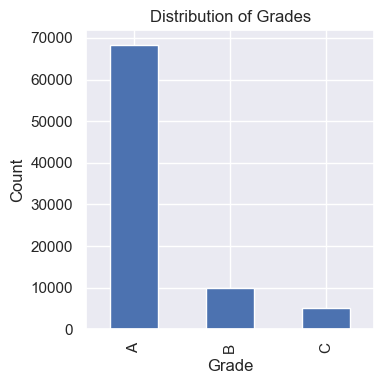

<Figure size 640x480 with 0 Axes>

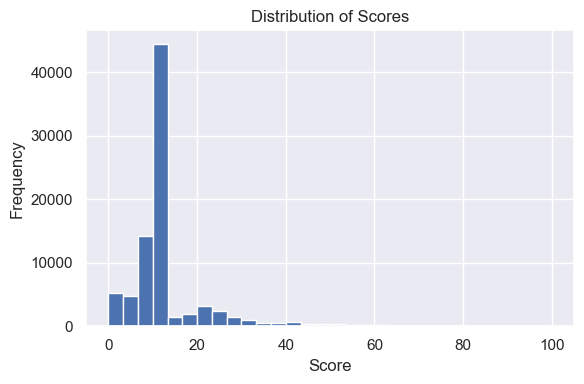


Grades by BORO:
GRADE              A     B     C
BORO                            
Bronx           5943  1020   472
Brooklyn       17929  2722  1456
Manhattan      25955  3366  1844
Queens         15828  2529  1329
Staten Island   2766   335   109


<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

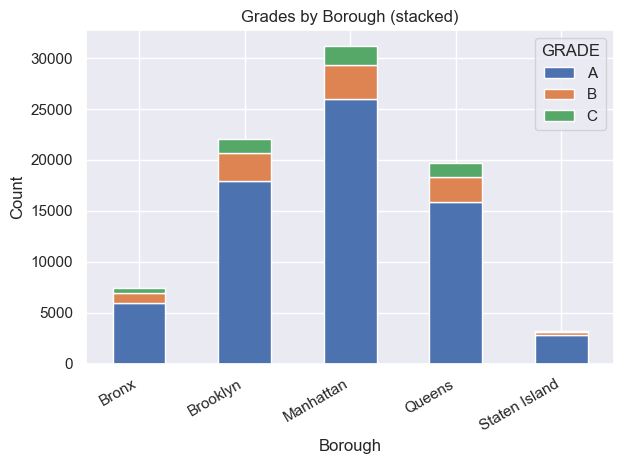


Average SCORE by year:
INSPECTION_YEAR
2012     7.000000
2013     2.500000
2015     8.000000
2016     9.719231
2017    10.506893
2018    11.560417
2019    12.689880
2020    12.378433
2021    12.305988
2022    13.243497
2023    13.889556
Name: SCORE, dtype: float64


<Figure size 640x480 with 0 Axes>

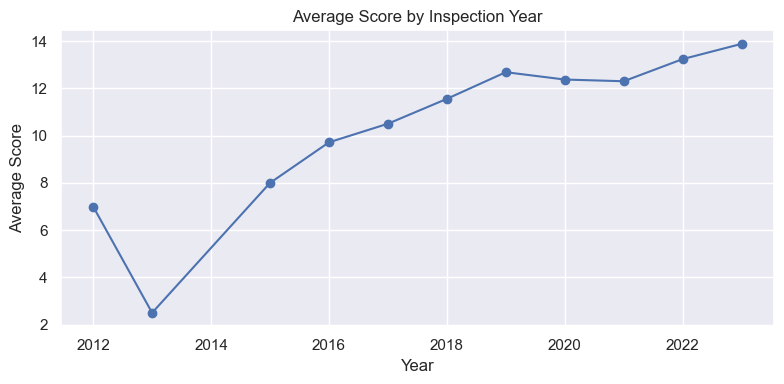

<Figure size 640x480 with 0 Axes>

In [11]:
def show_and_clear():
    plt.tight_layout()
    plt.show()
    plt.clf()

# 4.1 Grade distribution
print("\nGrade counts:")
print(df["GRADE"].value_counts())

plt.figure(figsize=(4, 4))
df["GRADE"].value_counts().loc[["A", "B", "C"]].plot(kind="bar")
plt.title("Distribution of Grades")
plt.xlabel("Grade")
plt.ylabel("Count")
show_and_clear()

# 4.2 Score distribution
plt.figure(figsize=(6, 4))
df["SCORE"].plot(kind="hist", bins=30)
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
show_and_clear()

# 4.3 Grades by borough
print("\nGrades by BORO:")
print(pd.crosstab(df["BORO"], df["GRADE"]))

plt.figure(figsize=(8, 5))
(pd.crosstab(df["BORO"], df["GRADE"])
   .loc[:, ["A", "B", "C"]]
   .plot(kind="bar", stacked=True))
plt.title("Grades by Borough (stacked)")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
show_and_clear()

# 4.4 Average score by year
yearly_scores = df.groupby("INSPECTION_YEAR")["SCORE"].mean().sort_index()
print("\nAverage SCORE by year:")
print(yearly_scores)

plt.figure(figsize=(8, 4))
yearly_scores.plot(marker="o")
plt.title("Average Score by Inspection Year")
plt.xlabel("Year")
plt.ylabel("Average Score")
show_and_clear()

## Simple Feature Engineering

In [12]:
# Set categorical types for key columns used in modeling
for col in ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

## Feature Matrix for Modeling

In [14]:
# --- Pre-inspection features only ---
feature_cols = [
    # Geographic features
    "Latitude",
    "Longitude",
    "BORO",
    "ZIPCODE",           # Neighborhood-level geographic feature
    "NTA",               # Neighborhood Tabulation Area
    "Community Board",   # Administrative boundary
    # Restaurant characteristics
    "CUISINE DESCRIPTION",
    # Temporal features
    "INSPECTION_YEAR",
    "INSPECTION_MONTH",
    # Restaurant history features (Phase 1)
    "num_prior_inspections",      # Number of prior inspections for this restaurant
    "prev_grade",                 # Grade from previous inspection
    "days_since_last_inspection", # Days since last inspection
]

X = df[feature_cols].copy()
y = df["GRADE"].copy()
groups = df["CAMIS"]  # still needed for grouped splitting

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique restaurants:", groups.nunique())

X shape: (83603, 12)
y shape: (83603,)
Unique restaurants: 21165


## Grouped 70/30 Train-test Split

In [15]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (58336, 12)
Test size: (25267, 12)


## SMOTE Upsampling for Class Imbalance

=== BEFORE SMOTE ===
Train set class distribution:
GRADE
A         47816
B          6863
C          3657
Closed        0
N             0
P             0
Z             0
Name: count, dtype: int64

Class proportions:
  A: 47,816 (82.0%)
  B: 6,863 (11.8%)
  C: 3,657 (6.3%)

=== AFTER SMOTE ===
Train set class distribution:
GRADE
A    47816
B    47816
C    47816
Name: count, dtype: int64

Class proportions:
  A: 47,816 (33.3%)
  B: 47,816 (33.3%)
  C: 47,816 (33.3%)

Original train size: 58,336
After SMOTE train size: 143,448
Increase: 85,112 samples (145.9%)


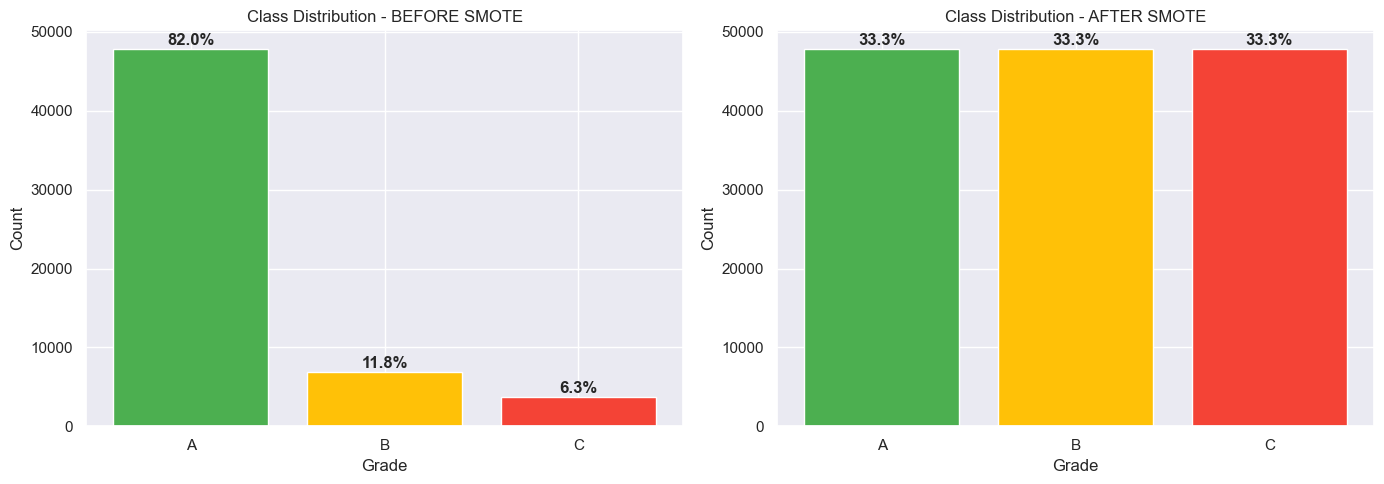

In [16]:
# Apply SMOTE to balance classes B and C
# SMOTE creates synthetic samples for minority classes

print("=== BEFORE SMOTE ===")
print("Train set class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nClass proportions:")
for grade in ["A", "B", "C"]:
    count = (y_train == grade).sum()
    pct = count / len(y_train) * 100
    print(f"  {grade}: {count:,} ({pct:.1f}%)")

# First, we need to preprocess the data before applying SMOTE
# SMOTE works on numeric features, so we need to encode categoricals first
preprocess_temp = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["BORO", "CUISINE DESCRIPTION", "ZIPCODE", "NTA", "Community Board", "prev_grade"]),
        ("num", "passthrough", ["Latitude", "Longitude", "INSPECTION_YEAR", "INSPECTION_MONTH", "num_prior_inspections", "days_since_last_inspection"]),
    ]
)

# Transform training data
X_train_encoded = preprocess_temp.fit_transform(X_train)

# Convert y_train to numeric for SMOTE FIRST (it needs numeric labels)
# This must be done before creating SMOTE with sampling_strategy
label_to_int = {"A": 0, "B": 1, "C": 2}
y_train_encoded = y_train.map(label_to_int)

# Calculate target counts based on encoded labels
# Class 0 (A) is the majority class
target_count_class_0 = (y_train_encoded == 0).sum()

# Apply SMOTE
# Strategy: upsample classes 1 (B) and 2 (C) to match class 0 (A)'s count
# IMPORTANT: Use numeric keys (0, 1, 2) that match the encoded labels
smote = SMOTE(
    sampling_strategy={0: target_count_class_0,  # Keep class 0 (A) as is
                      1: target_count_class_0,  # Upsample class 1 (B) to match A
                      2: target_count_class_0},  # Upsample class 2 (C) to match A
    random_state=42,
    k_neighbors=5  # Number of nearest neighbors for SMOTE
)

# Apply SMOTE
X_train_smote, y_train_smote_encoded = smote.fit_resample(X_train_encoded, y_train_encoded)

# Convert back to original labels
int_to_label = {0: "A", 1: "B", 2: "C"}
y_train_smote = pd.Series(y_train_smote_encoded).map(int_to_label)

print("\n=== AFTER SMOTE ===")
print("Train set class distribution:")
print(y_train_smote.value_counts().sort_index())
print(f"\nClass proportions:")
for grade in ["A", "B", "C"]:
    count = (y_train_smote == grade).sum()
    pct = count / len(y_train_smote) * 100
    print(f"  {grade}: {count:,} ({pct:.1f}%)")

print(f"\nOriginal train size: {len(y_train):,}")
print(f"After SMOTE train size: {len(y_train_smote):,}")
print(f"Increase: {len(y_train_smote) - len(y_train):,} samples ({((len(y_train_smote) / len(y_train)) - 1) * 100:.1f}%)")

# Visualize the class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
before_counts = y_train.value_counts().sort_index()
axes[0].bar(["A", "B", "C"], [before_counts["A"], before_counts["B"], before_counts["C"]], 
            color=["#4CAF50", "#FFC107", "#F44336"])
axes[0].set_title("Class Distribution - BEFORE SMOTE")
axes[0].set_xlabel("Grade")
axes[0].set_ylabel("Count")
for i, grade in enumerate(["A", "B", "C"]):
    count = before_counts[grade]
    pct = count / len(y_train) * 100
    axes[0].text(i, count + 500, f"{pct:.1f}%", ha="center", fontweight="bold")

# After SMOTE
after_counts = y_train_smote.value_counts().sort_index()
axes[1].bar(["A", "B", "C"], [after_counts["A"], after_counts["B"], after_counts["C"]], 
            color=["#4CAF50", "#FFC107", "#F44336"])
axes[1].set_title("Class Distribution - AFTER SMOTE")
axes[1].set_xlabel("Grade")
axes[1].set_ylabel("Count")
for i, grade in enumerate(["A", "B", "C"]):
    count = after_counts[grade]
    pct = count / len(y_train_smote) * 100
    axes[1].text(i, count + 500, f"{pct:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

# Note: X_train_smote is now a numpy array (encoded features)
# We'll need to use this for training models with SMOTE
# The original X_train (DataFrame) is preserved for reference


## Preprocessing for Categorical Variables

In [17]:
categorical_cols = ["BORO", "CUISINE DESCRIPTION", "ZIPCODE", "NTA", "Community Board", "prev_grade"]
numeric_cols = ["Latitude", "Longitude", "INSPECTION_YEAR", "INSPECTION_MONTH", "num_prior_inspections", "days_since_last_inspection"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

## Logistic Regression Model

In [18]:
# Logistic Regression - Linear baseline model for comparison
# Uses multinomial logistic regression for multi-class classification

def classification_report_df(y_true, y_pred):
    """Convert sklearn classification_report to pandas DataFrame."""
    report = classification_report(y_true, y_pred, output_dict=True)
    return pd.DataFrame(report).transpose()
    
lr_model = LogisticRegression(
    multi_class="multinomial",  # For multi-class classification
    solver="lbfgs",  # Good for small-medium datasets
    max_iter=1500,  # Increase iterations for convergence
    class_weight="balanced",  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Build pipeline: preprocess → model
lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lr_model),
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred = lr_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("=== Logistic Regression TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== Logistic Regression TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred = lr_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== Logistic Regression TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== Logistic Regression TEST CLASSIFICATION REPORT ===")
display(test_report_df)


c:\Users\Hero\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression TRAIN ACCURACY === 0.9432940208447613

=== Logistic Regression TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.961406,0.972122,0.966734,47816.000000
B,0.834566,0.789451,0.811382,6863.000000
C,0.894707,0.855072,0.874441,3657.000000
accuracy,0.943294,0.943294,0.943294,0.943294
macro avg,0.896893,0.872215,0.884185,58336.000000
weighted avg,0.942302,0.943294,0.942672,58336.000000



=== Logistic Regression TEST ACCURACY === 0.9418609253176079

=== Logistic Regression TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.959521,0.972094,0.965767,20605.000000
B,0.837384,0.786748,0.811277,3109.000000
C,0.898708,0.851256,0.874339,1553.000000
accuracy,0.941861,0.941861,0.941861,0.941861
macro avg,0.898538,0.870033,0.883794,25267.000000
weighted avg,0.940755,0.941861,0.941138,25267.000000


## Random Forest Classifier

In [19]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_model),
])

pipeline.fit(X_train, y_train)

# --- TRAIN EVAL ---
y_train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("=== Random Forest Classifier TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== Random Forest Classifier TRAIN REPORT ===")
display(train_report_df)


# --- TEST EVAL ---
y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("=== Random Forest Classifier TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== Random Forest Classifier TEST CLASSIFICATION REPORT ===")
display(test_report_df)


=== Random Forest Classifier TRAIN ACCURACY === 0.9999828579264948

=== Random Forest Classifier TRAIN REPORT ===


,precision,recall,f1-score,support
A,1.000000,0.999979,0.999990,47816.000000
B,1.000000,1.000000,1.000000,6863.000000
C,0.999727,1.000000,0.999863,3657.000000
accuracy,0.999983,0.999983,0.999983,0.999983
macro avg,0.999909,0.999993,0.999951,58336.000000
weighted avg,0.999983,0.999983,0.999983,58336.000000


=== Random Forest Classifier TEST ACCURACY === 0.9590374797166265

=== Random Forest Classifier TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.954282,0.997816,0.975563,20605.000000
B,0.984186,0.760695,0.858128,3109.000000
C,0.990902,0.841597,0.910167,1553.000000
accuracy,0.959037,0.959037,0.959037,0.959037
macro avg,0.976457,0.866703,0.914619,25267.000000
weighted avg,0.960212,0.959037,0.957094,25267.000000


## XGBoost Model

In [20]:
# -----------------------------
# 1. Encode labels A/B/C → 0/1/2
# -----------------------------
label_to_int = {"A": 0, "B": 1, "C": 2}
int_to_label = {v: k for k, v in label_to_int.items()}

y_train_enc = y_train.map(label_to_int)
y_test_enc  = y_test.map(label_to_int)

# -----------------------------
# 2. Compute sample weights to handle class imbalance
#    (still based on original labels, that's fine)
# -----------------------------
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# -----------------------------
# 3. Define XGBoost classifier
# -----------------------------
xgb_clf = XGBClassifier(
    objective="multi:softprob",   # probabilistic multi-class
    eval_metric="mlogloss",
    num_class=3,                  # 3 grades: A, B, C
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# 4. Build pipeline: preprocess → model
# -----------------------------
xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_clf),
])

# -----------------------------
# 5. Train with encoded labels
# -----------------------------
xgb_pipeline.fit(
    X_train,
    y_train_enc,
    model__sample_weight=sample_weights
)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred_enc = xgb_pipeline.predict(X_train)
# convert back to A/B/C for reporting
y_train_pred = pd.Series(y_train_pred_enc).map(int_to_label)

train_acc = accuracy_score(y_train, y_train_pred)
print("=== XGBoost TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== XGBoost TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred_enc = xgb_pipeline.predict(X_test)
y_test_pred = pd.Series(y_test_pred_enc).map(int_to_label)

test_acc = accuracy_score(y_test, y_test_pred)
print("\n=== XGBoost TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== XGBoost TEST CLASSIFICATION REPORT ===")
display(test_report_df)


=== XGBoost TRAIN ACCURACY === 0.9371914426769062

=== XGBoost TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.976881,0.948218,0.962336,47816.000000
B,0.736167,0.878187,0.800930,6863.000000
C,0.884636,0.903746,0.894089,3657.000000
accuracy,0.937191,0.937191,0.937191,0.937191
macro avg,0.865895,0.910051,0.885785,58336.000000
weighted avg,0.942780,0.937191,0.939069,58336.000000



=== XGBoost TEST ACCURACY === 0.9227055052044169

=== XGBoost TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.969111,0.940985,0.954841,20605.000000
B,0.711623,0.834995,0.768388,3109.000000
C,0.824442,0.855763,0.839810,1553.000000
accuracy,0.922706,0.922706,0.922706,0.922706
macro avg,0.835058,0.877248,0.854347,25267.000000
weighted avg,0.928536,0.922706,0.924829,25267.000000


## CatBoost Model

In [21]:
# -----------------------------
# 1. Encode labels A/B/C → 0/1/2
# -----------------------------
# Reuse the same label mappings from XGBoost
label_to_int = {"A": 0, "B": 1, "C": 2}
int_to_label = {v: k for k, v in label_to_int.items()}

y_train_enc = y_train.map(label_to_int)
y_test_enc  = y_test.map(label_to_int)

# -----------------------------
# 2. Prepare data for CatBoost with RAW categorical features
#    CatBoost's superpower is handling categorical features natively!
#    We'll use the raw DataFrame, not one-hot encoded
# -----------------------------
# Create copies of train/test with proper data types
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

# Ensure categorical columns are properly typed
categorical_feature_names = ["BORO", "CUISINE DESCRIPTION", "ZIPCODE", "NTA", "Community Board", "prev_grade"]
for col in categorical_feature_names:
    X_train_cb[col] = X_train_cb[col].astype("category")
    X_test_cb[col] = X_test_cb[col].astype("category")

# Identify categorical feature indices (0-indexed positions in the DataFrame)
categorical_indices = [X_train_cb.columns.get_loc(col) for col in categorical_feature_names]

print("Categorical feature indices:", categorical_indices)
print("Categorical features:", categorical_feature_names)

# -----------------------------
# 3. Use GENTLE, hand-tuned class weights (not auto-computed "balanced")
#    The prescription: A=1.0, B=2.0, C=3.0 or 4.0
#    This is a "nudge" not a "threat"
# -----------------------------
# Start with gentle weights: A=1.0, B=2.0, C=3.0
class_weights_list = [1.0, 2.0, 3.0]  # [weight_A, weight_B, weight_C]

print("\nUsing gentle class weights:")
print(f"  Class A (majority): {class_weights_list[0]}")
print(f"  Class B: {class_weights_list[1]}")
print(f"  Class C (minority): {class_weights_list[2]}")

# -----------------------------
# 4. Define CatBoost classifier with increased capacity
#    Depth: 6-8, Iterations: 500-800, Learning rate: 0.05-0.1
# -----------------------------
catboost_clf = CatBoostClassifier(
    iterations=600,  # Increased from 300
    depth=6,  # Increased from 4
    learning_rate=0.05,  # Slightly lower for more stable training
    loss_function="MultiClass",
    eval_metric="MultiClass",
    random_seed=42,
    verbose=False,
    allow_writing_files=False,
    class_weights=class_weights_list,  # Gentle hand-tuned weights
    cat_features=categorical_indices  # Let CatBoost handle categoricals natively!
    # NOTE: NO sample_weight - we're only using class_weights to avoid double-counting
)

# -----------------------------
# 5. Train CatBoost on RAW data (not preprocessed/one-hot encoded)
#    This lets CatBoost use its target-based encoding for categoricals
# -----------------------------
print("\nTraining CatBoost on raw data with native categorical handling...")
catboost_clf.fit(
    X_train_cb,
    y_train_enc
    # NO sample_weight - only using class_weights
)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred_enc = catboost_clf.predict(X_train_cb)
# CatBoost returns 2D array, need to flatten it
y_train_pred_enc = y_train_pred_enc.ravel() if len(y_train_pred_enc.shape) > 1 else y_train_pred_enc
# convert back to A/B/C for reporting
y_train_pred = pd.Series(y_train_pred_enc).map(int_to_label)

train_acc = accuracy_score(y_train, y_train_pred)
print("\n=== CatBoost TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== CatBoost TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred_enc = catboost_clf.predict(X_test_cb)
# CatBoost returns 2D array, need to flatten it
y_test_pred_enc = y_test_pred_enc.ravel() if len(y_test_pred_enc.shape) > 1 else y_test_pred_enc
y_test_pred = pd.Series(y_test_pred_enc).map(int_to_label)

test_acc = accuracy_score(y_test, y_test_pred)
print("\n=== CatBoost TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== CatBoost TEST CLASSIFICATION REPORT ===")
display(test_report_df)


Categorical feature indices: [2, 6, 3, 4, 5, 10]
Categorical features: ['BORO', 'CUISINE DESCRIPTION', 'ZIPCODE', 'NTA', 'Community Board', 'prev_grade']

Using gentle class weights:
  Class A (majority): 1.0
  Class B: 2.0
  Class C (minority): 3.0

Training CatBoost on raw data with native categorical handling...

=== CatBoost TRAIN ACCURACY === 0.9671386450905102

=== CatBoost TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.967426,0.993789,0.980430,47816.000000
B,0.963052,0.820341,0.885986,6863.000000
C,0.970039,0.894176,0.930563,3657.000000
accuracy,0.967139,0.967139,0.967139,0.967139
macro avg,0.966839,0.902768,0.932327,58336.000000
weighted avg,0.967075,0.967139,0.966193,58336.000000



=== CatBoost TEST ACCURACY === 0.9547235524597301

=== CatBoost TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.956033,0.990925,0.973166,20605.000000
B,0.945016,0.768414,0.847614,3109.000000
C,0.952243,0.847392,0.896763,1553.000000
accuracy,0.954724,0.954724,0.954724,0.954724
macro avg,0.951097,0.868910,0.905848,25267.000000
weighted avg,0.954445,0.954724,0.953022,25267.000000


## Models with SMOTE Upsampling

In [22]:
# Train models using SMOTE-upsampled data
# Note: X_train_smote is already preprocessed (encoded), so we'll train directly on it
# X_test still needs to be preprocessed using the same preprocessor

# Preprocess test data using the same preprocessor
X_test_encoded = preprocess_temp.transform(X_test)

print("=" * 70)
print("TRAINING MODELS WITH SMOTE-UPSAMPLED DATA")
print("=" * 70)

# ============================================
# 1. Random Forest with SMOTE
# ============================================
print("\n[1/4] Training Random Forest with SMOTE...")
rf_smote = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
    # Note: No class_weight needed since classes are balanced
)

rf_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_rf = pd.Series(rf_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_rf = pd.Series(rf_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_rf = accuracy_score(y_train_smote, y_train_pred_smote_rf)
test_acc_smote_rf = accuracy_score(y_test, y_test_pred_smote_rf)

print(f"  Train Accuracy: {train_acc_smote_rf:.4f}")
print(f"  Test Accuracy: {test_acc_smote_rf:.4f}")

# ============================================
# 2. XGBoost with SMOTE
# ============================================
print("\n[2/4] Training XGBoost with SMOTE...")
xgb_smote = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
    # Note: No sample weights needed since classes are balanced
)

xgb_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_xgb = pd.Series(xgb_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_xgb = pd.Series(xgb_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_xgb = accuracy_score(y_train_smote, y_train_pred_smote_xgb)
test_acc_smote_xgb = accuracy_score(y_test, y_test_pred_smote_xgb)

print(f"  Train Accuracy: {train_acc_smote_xgb:.4f}")
print(f"  Test Accuracy: {test_acc_smote_xgb:.4f}")

# ============================================
# 3. Logistic Regression with SMOTE
# ============================================
print("\n[3/4] Training Logistic Regression with SMOTE...")
lr_smote = LogisticRegression(
    solver="lbfgs",
    max_iter=1500,
    random_state=42,
    n_jobs=-1
    # Note: No class_weight needed since classes are balanced
)

lr_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_lr = pd.Series(lr_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_lr = pd.Series(lr_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_lr = accuracy_score(y_train_smote, y_train_pred_smote_lr)
test_acc_smote_lr = accuracy_score(y_test, y_test_pred_smote_lr)

print(f"  Train Accuracy: {train_acc_smote_lr:.4f}")
print(f"  Test Accuracy: {test_acc_smote_lr:.4f}")

# ============================================
# 4. CatBoost with SMOTE
# ============================================
print("\n[4/4] Training CatBoost with SMOTE...")
catboost_smote = CatBoostClassifier(
    iterations=300,
    depth=4,
    learning_rate=0.1,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    random_seed=42,
    verbose=False,
    allow_writing_files=False  # Prevent creation of catboost_info folder
    # Note: No class weights needed since classes are balanced
)

catboost_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
# CatBoost returns 2D array, need to flatten it
y_train_pred_smote_cb_enc = catboost_smote.predict(X_train_smote)
y_train_pred_smote_cb_enc = y_train_pred_smote_cb_enc.ravel() if len(y_train_pred_smote_cb_enc.shape) > 1 else y_train_pred_smote_cb_enc
y_train_pred_smote_cb = pd.Series(y_train_pred_smote_cb_enc).map(int_to_label)

y_test_pred_smote_cb_enc = catboost_smote.predict(X_test_encoded)
y_test_pred_smote_cb_enc = y_test_pred_smote_cb_enc.ravel() if len(y_test_pred_smote_cb_enc.shape) > 1 else y_test_pred_smote_cb_enc
y_test_pred_smote_cb = pd.Series(y_test_pred_smote_cb_enc).map(int_to_label)

# Evaluation
train_acc_smote_cb = accuracy_score(y_train_smote, y_train_pred_smote_cb)
test_acc_smote_cb = accuracy_score(y_test, y_test_pred_smote_cb)

print(f"  Train Accuracy: {train_acc_smote_cb:.4f}")
print(f"  Test Accuracy: {test_acc_smote_cb:.4f}")

print("\n" + "=" * 70)


TRAINING MODELS WITH SMOTE-UPSAMPLED DATA

[1/4] Training Random Forest with SMOTE...
  Train Accuracy: 1.0000
  Test Accuracy: 0.9571

[2/4] Training XGBoost with SMOTE...
  Train Accuracy: 0.9727
  Test Accuracy: 0.9605

[3/4] Training Logistic Regression with SMOTE...
  Train Accuracy: 0.8980
  Test Accuracy: 0.9461

[4/4] Training CatBoost with SMOTE...
  Train Accuracy: 0.9540
  Test Accuracy: 0.9598



## SMOTE vs Class Weight Comparison

COMPARISON: Class Weight vs SMOTE Upsampling

Test Set Accuracy Comparison:


,Model,Class Weight (Test Acc),SMOTE (Test Acc),Improvement
0,Random Forest,0.9590,0.9571,-0.1939
1,XGBoost,0.9227,0.9605,3.7836
2,CatBoost,0.9547,0.9598,0.5066
3,Logistic Regression,0.9419,0.9461,0.4274


DETAILED PER-CLASS METRICS: Logistic Regression

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.9595,0.9721,0.9658,20605.0000
B,0.8374,0.7867,0.8113,3109.0000
C,0.8987,0.8513,0.8743,1553.0000
accuracy,0.9419,0.9419,0.9419,0.9419
macro avg,0.8985,0.8700,0.8838,25267.0000
weighted avg,0.9408,0.9419,0.9411,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.9583,0.9788,0.9685,20605.0000
B,0.8779,0.7768,0.8242,3109.0000
C,0.8999,0.8513,0.8749,1553.0000
accuracy,0.9461,0.9461,0.9461,0.9461
macro avg,0.9120,0.8690,0.8892,25267.0000
weighted avg,0.9448,0.9461,0.9450,25267.0000



DETAILED PER-CLASS METRICS: Random Forest

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.9543,0.9978,0.9756,20605.000
B,0.9842,0.7607,0.8581,3109.000
C,0.9909,0.8416,0.9102,1553.000
accuracy,0.9590,0.9590,0.9590,0.959
macro avg,0.9765,0.8667,0.9146,25267.000
weighted avg,0.9602,0.9590,0.9571,25267.000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.9553,0.9946,0.9745,20605.0000
B,0.9604,0.7649,0.8516,3109.0000
C,0.9806,0.8442,0.9073,1553.0000
accuracy,0.9571,0.9571,0.9571,0.9571
macro avg,0.9654,0.8679,0.9111,25267.0000
weighted avg,0.9574,0.9571,0.9553,25267.0000



DETAILED PER-CLASS METRICS: XGBoost

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.9691,0.9410,0.9548,20605.0000
B,0.7116,0.8350,0.7684,3109.0000
C,0.8244,0.8558,0.8398,1553.0000
accuracy,0.9227,0.9227,0.9227,0.9227
macro avg,0.8351,0.8772,0.8543,25267.0000
weighted avg,0.9285,0.9227,0.9248,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.9540,0.9999,0.9764,20605.0000
B,0.9992,0.7591,0.8627,3109.0000
C,0.9985,0.8416,0.9133,1553.0000
accuracy,0.9605,0.9605,0.9605,0.9605
macro avg,0.9839,0.8669,0.9175,25267.0000
weighted avg,0.9623,0.9605,0.9586,25267.0000



DETAILED PER-CLASS METRICS: CatBoost

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.9560,0.9909,0.9732,20605.0000
B,0.9450,0.7684,0.8476,3109.0000
C,0.9522,0.8474,0.8968,1553.0000
accuracy,0.9547,0.9547,0.9547,0.9547
macro avg,0.9511,0.8689,0.9058,25267.0000
weighted avg,0.9544,0.9547,0.9530,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.9542,0.9987,0.9760,20605.0000
B,0.9929,0.7607,0.8614,3109.0000
C,0.9909,0.8422,0.9105,1553.0000
accuracy,0.9598,0.9598,0.9598,0.9598
macro avg,0.9793,0.8672,0.9160,25267.0000
weighted avg,0.9612,0.9598,0.9578,25267.0000


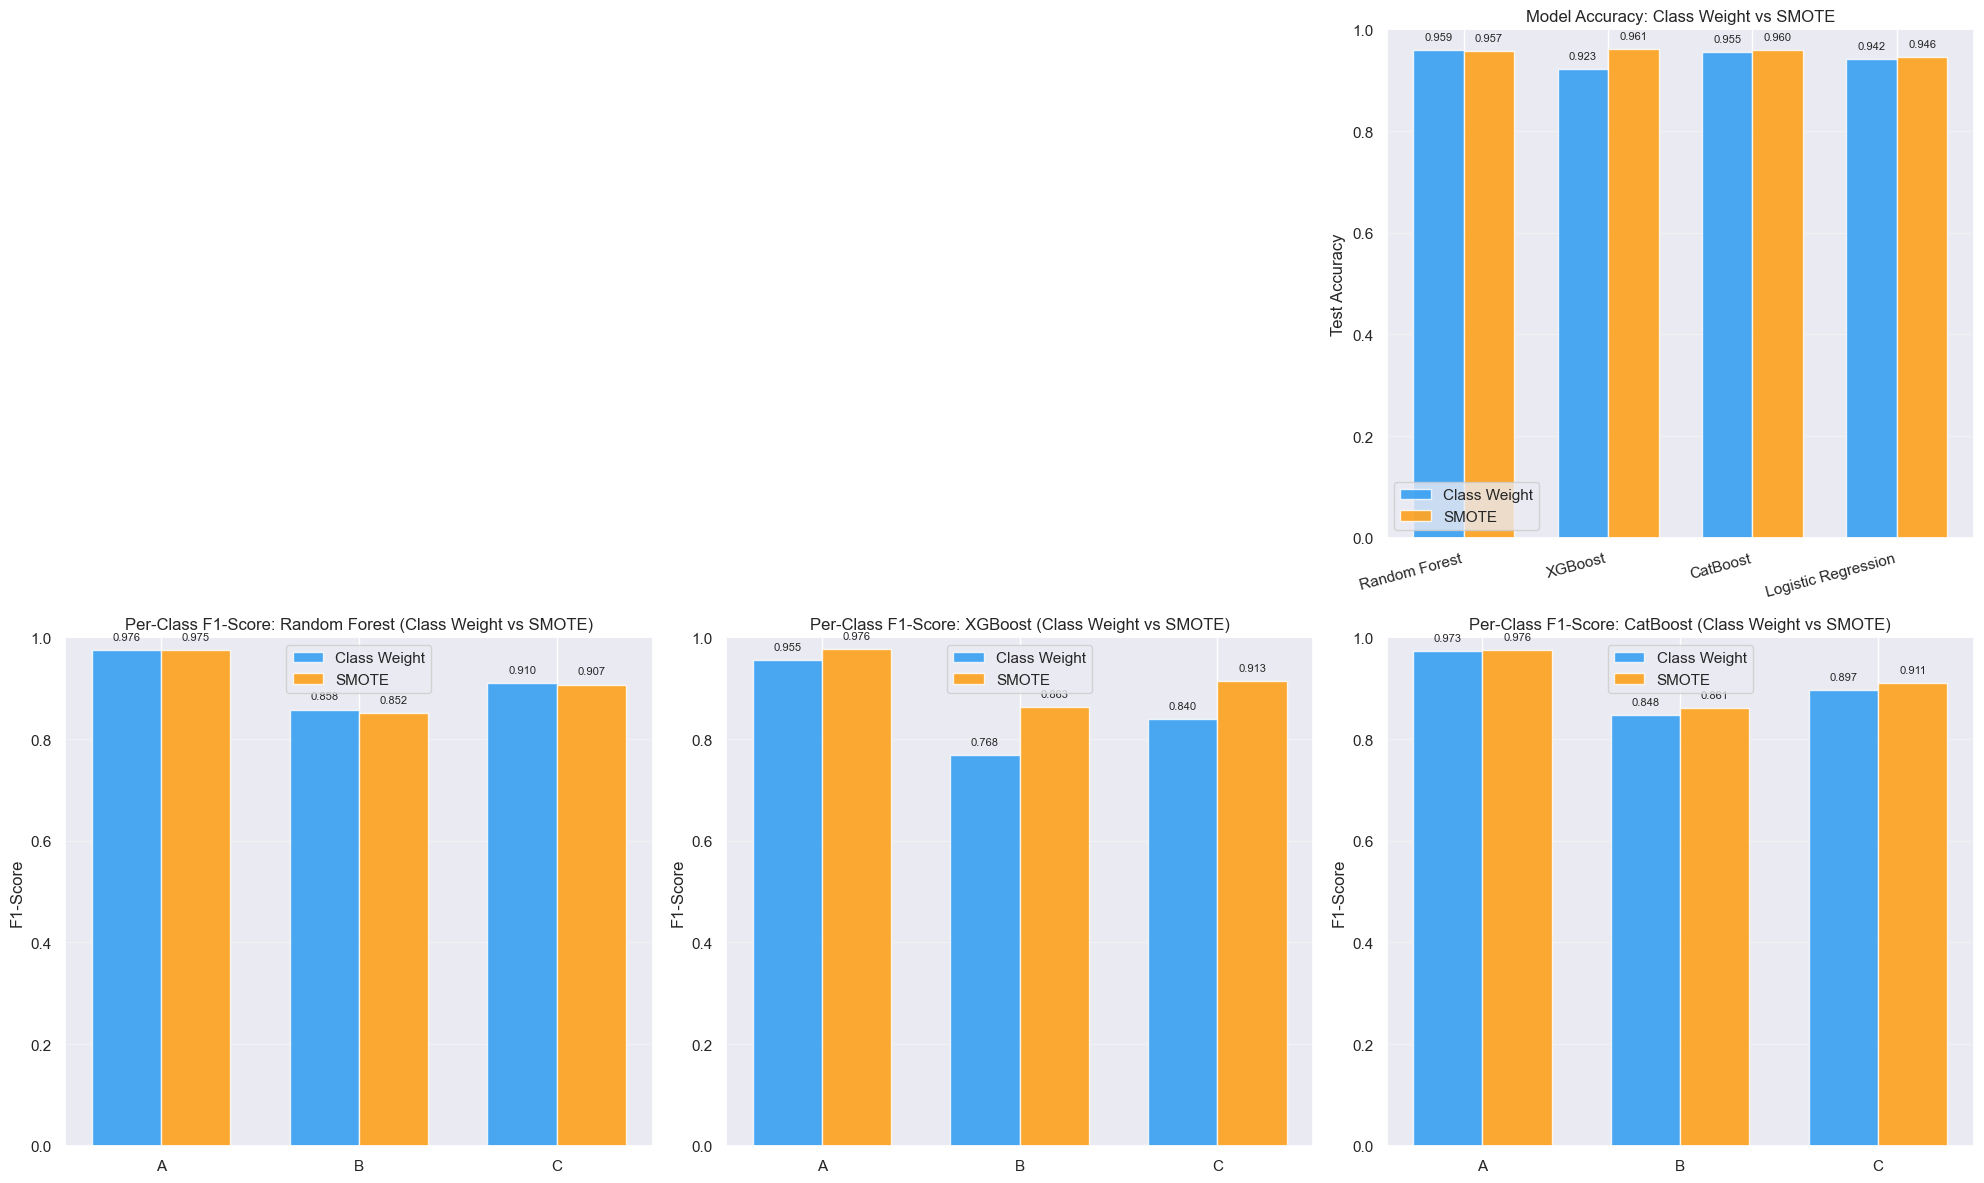

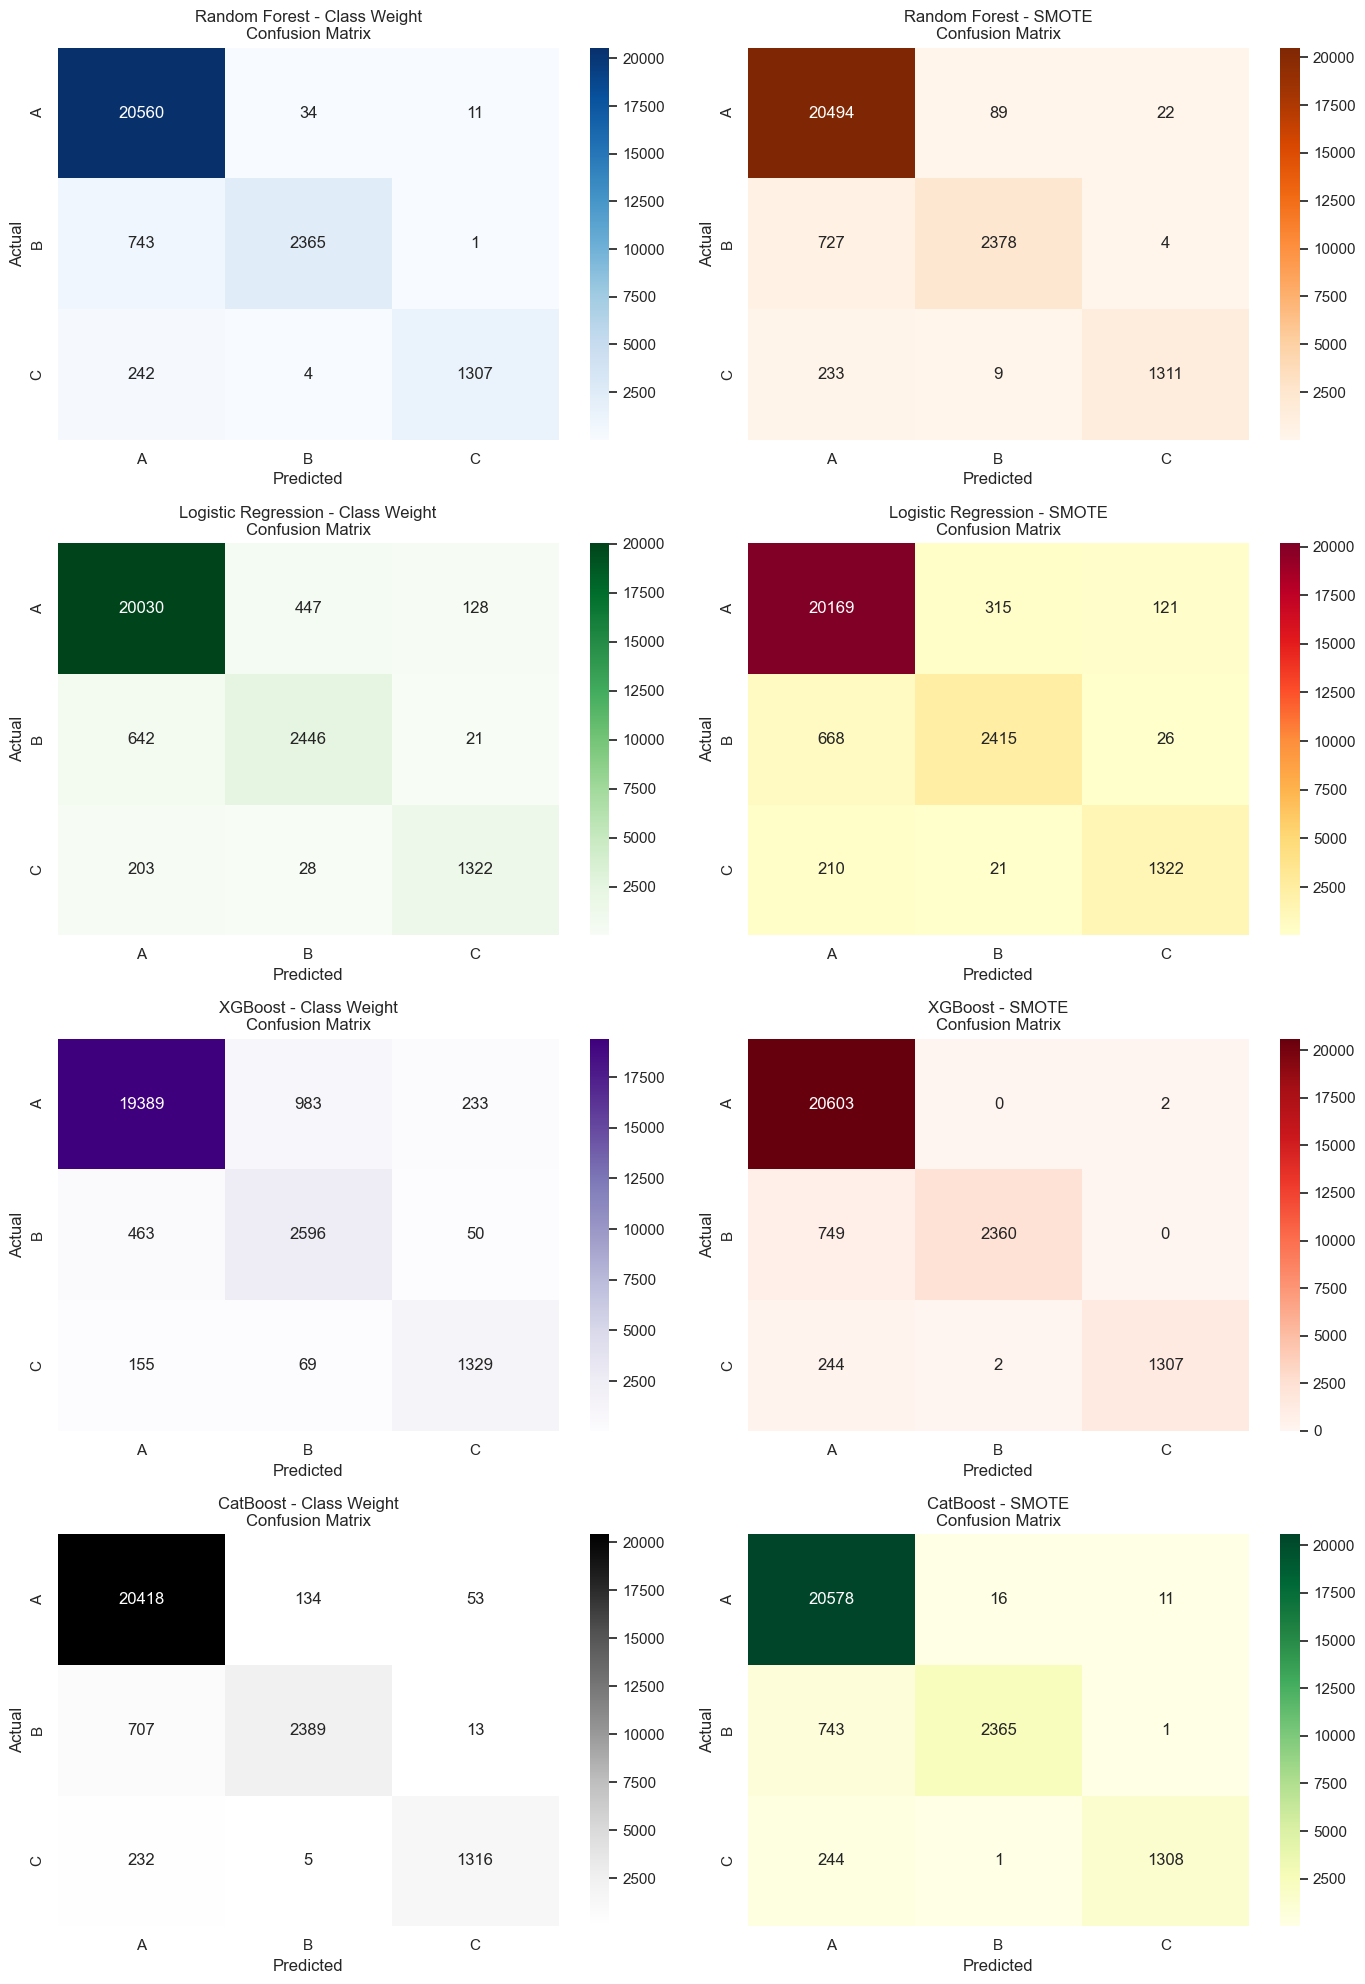


KEY INSIGHTS:
1. SMOTE creates synthetic samples for minority classes (B and C)
2. This should improve recall for B and C classes
3. Compare the confusion matrices to see if B/C predictions improved
4. Check if overall accuracy improved or if it's a trade-off


In [23]:
# Comprehensive comparison: SMOTE vs Class Weight approaches

# Get original model accuracies (from previous cells)
rf_acc_original = accuracy_score(y_test, pipeline.predict(X_test))
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_acc_original = accuracy_score(y_test, xgb_preds_original)
lr_acc_original = accuracy_score(y_test, lr_pipeline.predict(X_test))
# CatBoost returns 2D array, need to flatten it
# Use X_test_cb (raw data) instead of X_test_processed
cb_preds_original_enc = catboost_clf.predict(X_test_cb)
cb_preds_original_enc = cb_preds_original_enc.ravel() if len(cb_preds_original_enc.shape) > 1 else cb_preds_original_enc
cb_preds_original = pd.Series(cb_preds_original_enc).map({0: "A", 1: "B", 2: "C"})
cb_acc_original = accuracy_score(y_test, cb_preds_original)

# Create comparison DataFrame
comparison_data = {
    "Model": ["Random Forest", "XGBoost", "CatBoost", "Logistic Regression"],
    "Class Weight (Test Acc)": [rf_acc_original, xgb_acc_original, cb_acc_original, lr_acc_original],
    "SMOTE (Test Acc)": [test_acc_smote_rf, test_acc_smote_xgb, test_acc_smote_cb, test_acc_smote_lr],
    "Improvement": [
        test_acc_smote_rf - rf_acc_original,
        test_acc_smote_xgb - xgb_acc_original,
        test_acc_smote_cb - cb_acc_original,
        test_acc_smote_lr - lr_acc_original
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Improvement"] = comparison_df["Improvement"] * 100  # Convert to percentage points

print("=" * 70)
print("COMPARISON: Class Weight vs SMOTE Upsampling")
print("=" * 70)
print("\nTest Set Accuracy Comparison:")
display(comparison_df.round(4))

# Detailed per-class metrics for Logistic Regression
print("=" * 70)
print("DETAILED PER-CLASS METRICS: Logistic Regression")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
lr_report_original = classification_report(y_test, lr_pipeline.predict(X_test), output_dict=True)
lr_df_original = pd.DataFrame(lr_report_original).transpose()
display(lr_df_original.round(4))

print("\n--- WITH SMOTE ---")
lr_report_smote = classification_report(y_test, y_test_pred_smote_lr, output_dict=True)
lr_df_smote = pd.DataFrame(lr_report_smote).transpose()
display(lr_df_smote.round(4))

# Detailed per-class metrics for Random Forest
print("\n" + "=" * 70)
print("DETAILED PER-CLASS METRICS: Random Forest")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
rf_report_original = classification_report(y_test, pipeline.predict(X_test), output_dict=True)
rf_df_original = pd.DataFrame(rf_report_original).transpose()
display(rf_df_original.round(4))

print("\n--- WITH SMOTE ---")
rf_report_smote = classification_report(y_test, y_test_pred_smote_rf, output_dict=True)
rf_df_smote = pd.DataFrame(rf_report_smote).transpose()
display(rf_df_smote.round(4))

# Detailed per-class metrics for XGBoost
print("\n" + "=" * 70)
print("DETAILED PER-CLASS METRICS: XGBoost")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_report_original = classification_report(y_test, xgb_preds_original, output_dict=True)
xgb_df_original = pd.DataFrame(xgb_report_original).transpose()
display(xgb_df_original.round(4))

print("\n--- WITH SMOTE ---")
xgb_report_smote = classification_report(y_test, y_test_pred_smote_xgb, output_dict=True)
xgb_df_smote = pd.DataFrame(xgb_report_smote).transpose()
display(xgb_df_smote.round(4))

# Detailed per-class metrics for CatBoost
print("\n" + "=" * 70)
print("DETAILED PER-CLASS METRICS: CatBoost")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
# CatBoost returns 2D array, need to flatten it (reuse from above if already computed)
if 'cb_preds_original' not in locals():
    cb_preds_original_enc = catboost_clf.predict(X_test_cb)  # Use raw data
    cb_preds_original_enc = cb_preds_original_enc.ravel() if len(cb_preds_original_enc.shape) > 1 else cb_preds_original_enc
    cb_preds_original = pd.Series(cb_preds_original_enc).map({0: "A", 1: "B", 2: "C"})
cb_report_original = classification_report(y_test, cb_preds_original, output_dict=True)
cb_df_original = pd.DataFrame(cb_report_original).transpose()
display(cb_df_original.round(4))

print("\n--- WITH SMOTE ---")
cb_report_smote = classification_report(y_test, y_test_pred_smote_cb, output_dict=True)
cb_df_smote = pd.DataFrame(cb_report_smote).transpose()
display(cb_df_smote.round(4))


# Visual comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Accuracy comparison bar chart (spans 2 columns)
axes[0, 0].axis('off')  # Remove empty subplot
axes[0, 1].axis('off')  # Remove empty subplot
x = np.arange(len(comparison_df))
width = 0.35
axes[0, 2].bar(x - width/2, comparison_df["Class Weight (Test Acc)"], width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[0, 2].bar(x + width/2, comparison_df["SMOTE (Test Acc)"], width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[0, 2].set_ylabel("Test Accuracy")
axes[0, 2].set_title("Model Accuracy: Class Weight vs SMOTE")
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(comparison_df["Model"], rotation=15, ha="right")
axes[0, 2].set_ylim(0, 1)
axes[0, 2].legend()
axes[0, 2].grid(axis="y", alpha=0.3)

# Add value labels
for i, (orig, smote) in enumerate(zip(comparison_df["Class Weight (Test Acc)"], 
                                       comparison_df["SMOTE (Test Acc)"])):
    axes[0, 2].text(i - width/2, orig + 0.02, f"{orig:.3f}", ha="center", fontsize=8)
    axes[0, 2].text(i + width/2, smote + 0.02, f"{smote:.3f}", ha="center", fontsize=8)

# 2. Per-class F1 score comparison (Random Forest)
classes = ["A", "B", "C"]
f1_class_weight_rf = [rf_report_original[cls]["f1-score"] for cls in classes]
f1_smote_rf = [rf_report_smote[cls]["f1-score"] for cls in classes]

x2 = np.arange(len(classes))
axes[1, 0].bar(x2 - width/2, f1_class_weight_rf, width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[1, 0].bar(x2 + width/2, f1_smote_rf, width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[1, 0].set_ylabel("F1-Score")
axes[1, 0].set_title("Per-Class F1-Score: Random Forest (Class Weight vs SMOTE)")
axes[1, 0].set_xticks(x2)
axes[1, 0].set_xticklabels(classes)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend()
axes[1, 0].grid(axis="y", alpha=0.3)

# Add value labels for Random Forest
for i, (cw, sm) in enumerate(zip(f1_class_weight_rf, f1_smote_rf)):
    axes[1, 0].text(i - width/2, cw + 0.02, f"{cw:.3f}", ha="center", fontsize=8)
    axes[1, 0].text(i + width/2, sm + 0.02, f"{sm:.3f}", ha="center", fontsize=8)

# 3. Per-class F1 score comparison (XGBoost)
f1_class_weight_xgb = [xgb_report_original[cls]["f1-score"] for cls in classes]
f1_smote_xgb = [xgb_report_smote[cls]["f1-score"] for cls in classes]

x2 = np.arange(len(classes))
axes[1, 1].bar(x2 - width/2, f1_class_weight_xgb, width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[1, 1].bar(x2 + width/2, f1_smote_xgb, width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[1, 1].set_ylabel("F1-Score")
axes[1, 1].set_title("Per-Class F1-Score: XGBoost (Class Weight vs SMOTE)")
axes[1, 1].set_xticks(x2)
axes[1, 1].set_xticklabels(classes)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()
axes[1, 1].grid(axis="y", alpha=0.3)

# Add value labels for XGBoost
for i, (cw, sm) in enumerate(zip(f1_class_weight_xgb, f1_smote_xgb)):
    axes[1, 1].text(i - width/2, cw + 0.02, f"{cw:.3f}", ha="center", fontsize=8)
    axes[1, 1].text(i + width/2, sm + 0.02, f"{sm:.3f}", ha="center", fontsize=8)

# 4. Per-class F1 score comparison (CatBoost)
f1_class_weight_cb = [cb_report_original[cls]["f1-score"] for cls in classes]
f1_smote_cb = [cb_report_smote[cls]["f1-score"] for cls in classes]

x2 = np.arange(len(classes))
axes[1, 2].bar(x2 - width/2, f1_class_weight_cb, width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[1, 2].bar(x2 + width/2, f1_smote_cb, width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[1, 2].set_ylabel("F1-Score")
axes[1, 2].set_title("Per-Class F1-Score: CatBoost (Class Weight vs SMOTE)")
axes[1, 2].set_xticks(x2)
axes[1, 2].set_xticklabels(classes)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].legend()
axes[1, 2].grid(axis="y", alpha=0.3)

# Add value labels for CatBoost
for i, (cw, sm) in enumerate(zip(f1_class_weight_cb, f1_smote_cb)):
    axes[1, 2].text(i - width/2, cw + 0.02, f"{cw:.3f}", ha="center", fontsize=8)
    axes[1, 2].text(i + width/2, sm + 0.02, f"{sm:.3f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()

# Confusion matrices comparison - All Models
fig, axes = plt.subplots(4, 2, figsize=(14, 20))

# Row 1: Logistic Regression
# Class Weight confusion matrix
cm_lr_original = confusion_matrix(y_test, lr_pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(cm_lr_original, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1, 0])
axes[1, 0].set_title("Logistic Regression - Class Weight\nConfusion Matrix")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_lr_smote = confusion_matrix(y_test, y_test_pred_smote_lr, labels=["A", "B", "C"])
sns.heatmap(cm_lr_smote, annot=True, fmt="d", cmap="YlOrRd", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1, 1])
axes[1, 1].set_title("Logistic Regression - SMOTE\nConfusion Matrix")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")

# Row 2: Random Forest
# Class Weight confusion matrix
cm_rf_original = confusion_matrix(y_test, pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(cm_rf_original, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[0, 0])
axes[0, 0].set_title("Random Forest - Class Weight\nConfusion Matrix")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_rf_smote = confusion_matrix(y_test, y_test_pred_smote_rf, labels=["A", "B", "C"])
sns.heatmap(cm_rf_smote, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[0, 1])
axes[0, 1].set_title("Random Forest - SMOTE\nConfusion Matrix")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("Actual")

# Row 3: XGBoost
# Class Weight confusion matrix
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
cm_xgb_original = confusion_matrix(y_test, xgb_preds_original, labels=["A", "B", "C"])
sns.heatmap(cm_xgb_original, annot=True, fmt="d", cmap="Purples", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[2, 0])
axes[2, 0].set_title("XGBoost - Class Weight\nConfusion Matrix")
axes[2, 0].set_xlabel("Predicted")
axes[2, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_xgb_smote = confusion_matrix(y_test, y_test_pred_smote_xgb, labels=["A", "B", "C"])
sns.heatmap(cm_xgb_smote, annot=True, fmt="d", cmap="Reds", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[2, 1])
axes[2, 1].set_title("XGBoost - SMOTE\nConfusion Matrix")
axes[2, 1].set_xlabel("Predicted")
axes[2, 1].set_ylabel("Actual")

# Row 4: CatBoost
# Class Weight confusion matrix
# Reuse cb_preds_original from above if already computed
if 'cb_preds_original' not in locals():
    cb_preds_original_enc = catboost_clf.predict(X_test_cb)  # Use raw data
    cb_preds_original_enc = cb_preds_original_enc.ravel() if len(cb_preds_original_enc.shape) > 1 else cb_preds_original_enc
    cb_preds_original = pd.Series(cb_preds_original_enc).map({0: "A", 1: "B", 2: "C"})
cm_cb_original = confusion_matrix(y_test, cb_preds_original, labels=["A", "B", "C"])
sns.heatmap(cm_cb_original, annot=True, fmt="d", cmap="Greys", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[3, 0])
axes[3, 0].set_title("CatBoost - Class Weight\nConfusion Matrix")
axes[3, 0].set_xlabel("Predicted")
axes[3, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_cb_smote = confusion_matrix(y_test, y_test_pred_smote_cb, labels=["A", "B", "C"])
sns.heatmap(cm_cb_smote, annot=True, fmt="d", cmap="YlGn", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[3, 1])
axes[3, 1].set_title("CatBoost - SMOTE\nConfusion Matrix")
axes[3, 1].set_xlabel("Predicted")
axes[3, 1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
print("1. SMOTE creates synthetic samples for minority classes (B and C)")
print("2. This should improve recall for B and C classes")
print("3. Compare the confusion matrices to see if B/C predictions improved")
print("4. Check if overall accuracy improved or if it's a trade-off")
print("=" * 70)


## Feature Importance

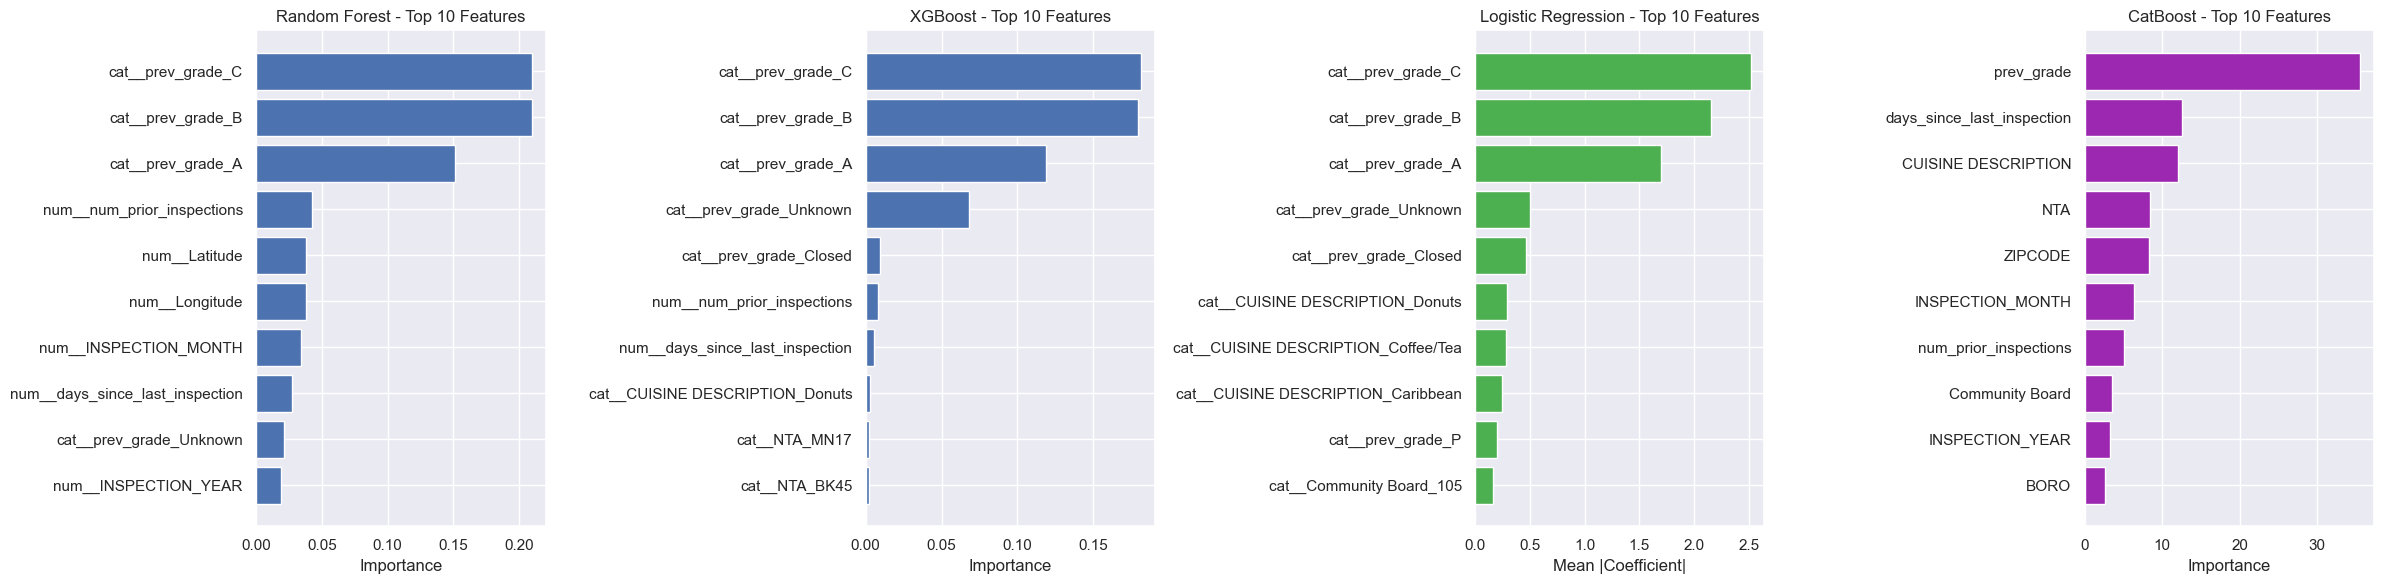

In [24]:
# Feature Importance Comparison
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Get feature names from the preprocessor
feature_names = preprocess.get_feature_names_out()
n_features = len(feature_names)
n_top = min(10, n_features)  # Use all features if we have fewer than 10

# Logistic Regression feature importance (using absolute coefficient values)
# For multinomial logistic regression, use mean absolute coefficients across all classes
lr_coef = lr_pipeline.named_steps["model"].coef_  # Shape: (n_classes, n_features)
lr_importances = np.mean(np.abs(lr_coef), axis=0)  # Average absolute coefficients across classes
lr_top_idx = lr_importances.argsort()[-n_top:][::-1]
axes[2].barh(range(n_top), lr_importances[lr_top_idx][::-1], color="#4CAF50")
axes[2].set_yticks(range(n_top))
axes[2].set_yticklabels([feature_names[i] for i in lr_top_idx][::-1])
axes[2].set_xlabel("Mean |Coefficient|")
axes[2].set_title(f"Logistic Regression - Top {n_top} Features")

# Random Forest feature importance
rf_importances = pipeline.named_steps["model"].feature_importances_
rf_top_idx = rf_importances.argsort()[-n_top:][::-1]
axes[0].barh(range(n_top), rf_importances[rf_top_idx][::-1])
axes[0].set_yticks(range(n_top))
axes[0].set_yticklabels([feature_names[i] for i in rf_top_idx][::-1])
axes[0].set_xlabel("Importance")
axes[0].set_title(f"Random Forest - Top {n_top} Features")

# XGBoost feature importance
xgb_importances = xgb_pipeline.named_steps["model"].feature_importances_
xgb_top_idx = xgb_importances.argsort()[-n_top:][::-1]
axes[1].barh(range(n_top), xgb_importances[xgb_top_idx][::-1])
axes[1].set_yticks(range(n_top))
axes[1].set_yticklabels([feature_names[i] for i in xgb_top_idx][::-1])
axes[1].set_xlabel("Importance")
axes[1].set_title(f"XGBoost - Top {n_top} Features")

# CatBoost feature importance
# Note: CatBoost uses raw features, so we need to map to feature names differently
# CatBoost feature importances correspond to the raw feature order
cb_importances = catboost_clf.feature_importances_
raw_feature_names = list(X_train_cb.columns)
n_cb_features = len(cb_importances)  # CatBoost has different number of features (raw, not preprocessed)
n_top_cb = min(10, n_cb_features)  # Calculate n_top separately for CatBoost

cb_top_idx = cb_importances.argsort()[-n_top_cb:][::-1]
cb_top_feature_names = [raw_feature_names[i] for i in cb_top_idx]

axes[3].barh(range(n_top_cb), cb_importances[cb_top_idx][::-1], color="#9C27B0")
axes[3].set_yticks(range(n_top_cb))
axes[3].set_yticklabels(cb_top_feature_names[::-1])
axes[3].set_xlabel("Importance")
axes[3].set_title(f"CatBoost - Top {n_top_cb} Features")

plt.tight_layout()
plt.show()

## Geographic Distribution

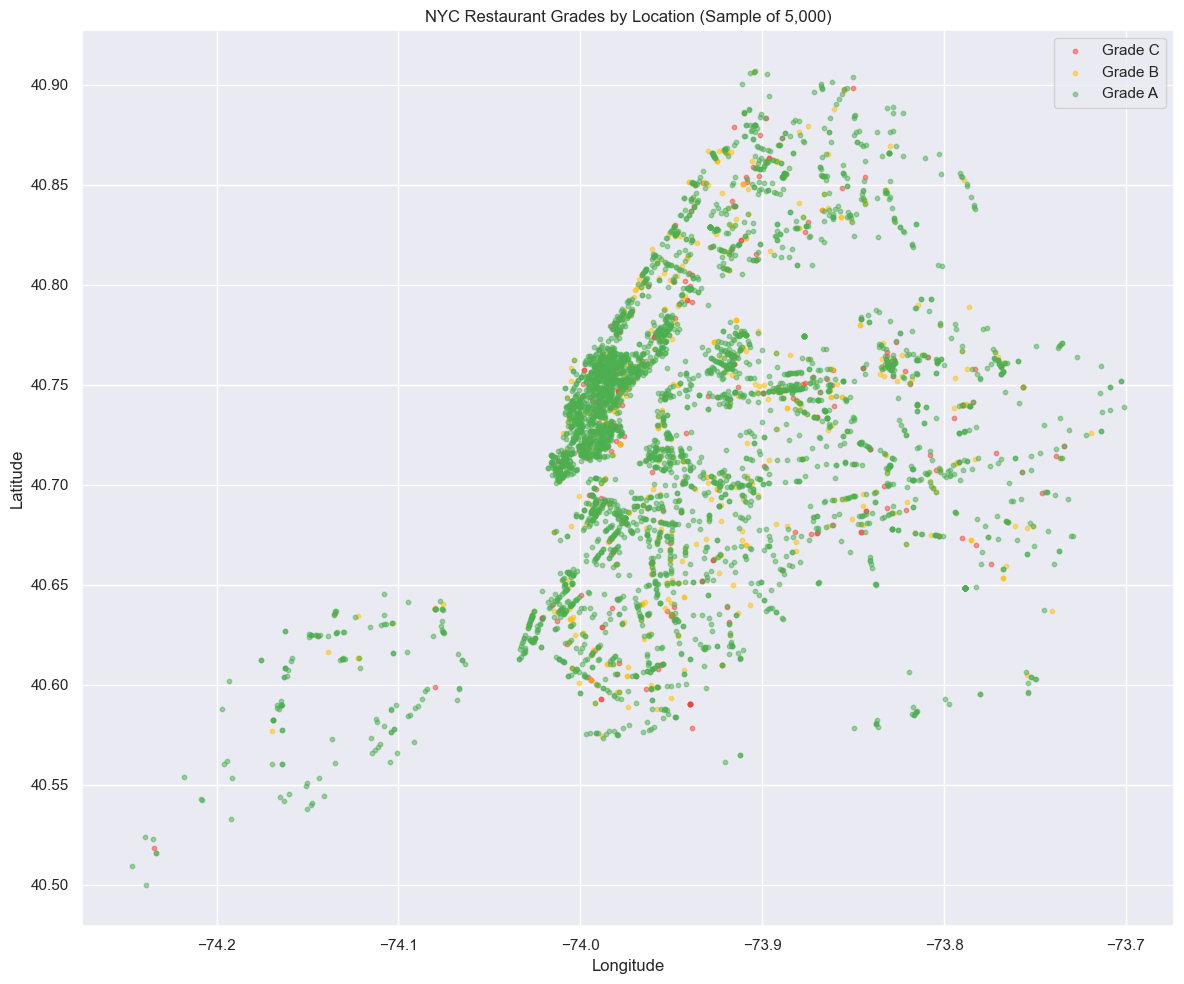

In [25]:
# Geographic Distribution of Grades
fig, ax = plt.subplots(figsize=(12, 10))

# Sample for performance (plotting 80k+ points is slow)
sample_df = df.sample(n=5000, random_state=42)

colors_map = {"A": "#4CAF50", "B": "#FFC107", "C": "#F44336"}
for grade in ["C", "B", "A"]:  # Plot A last so it doesn't cover the others
    subset = sample_df[sample_df["GRADE"] == grade]
    ax.scatter(subset["Longitude"], subset["Latitude"], 
               c=colors_map[grade], label=f"Grade {grade}", alpha=0.5, s=10)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NYC Restaurant Grades by Location (Sample of 5,000)")
ax.legend()
plt.tight_layout()
plt.show()

## Model Performance Comparison

=== MODEL PERFORMANCE COMPARISON (TEST SET) ===



,Random Forest,XGBoost,CatBoost,Logistic Regression,Winner
Accuracy,0.9590,0.9227,0.9547,0.9419,Random Forest
Precision,0.9602,0.9285,0.9544,0.9408,Random Forest
Recall,0.9590,0.9227,0.9547,0.9419,Random Forest
F1-Score,0.9571,0.9248,0.9530,0.9411,Random Forest


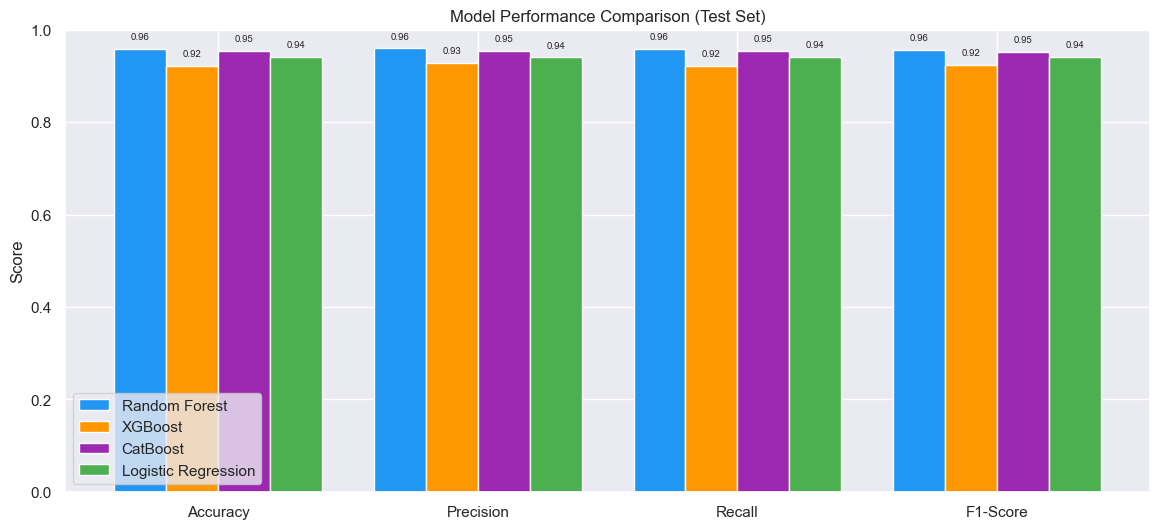

In [26]:
# Get predictions
rf_preds = pipeline.predict(X_test)
xgb_preds_encoded = xgb_pipeline.predict(X_test)
xgb_preds = pd.Series(xgb_preds_encoded).map({0: "A", 1: "B", 2: "C"})
# CatBoost returns 2D array, need to flatten it
# Use X_test_cb (raw data) instead of X_test_processed
cb_preds_encoded = catboost_clf.predict(X_test_cb)
cb_preds_encoded = cb_preds_encoded.ravel() if len(cb_preds_encoded.shape) > 1 else cb_preds_encoded
cb_preds = pd.Series(cb_preds_encoded).map({0: "A", 1: "B", 2: "C"})
lr_preds = lr_pipeline.predict(X_test)

# Calculate metrics (weighted average to handle imbalance)
metrics = {
    "Accuracy": [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds),
        accuracy_score(y_test, cb_preds),
        accuracy_score(y_test, lr_preds)
    ],
    "Precision": [
        precision_score(y_test, rf_preds, average="weighted"),
        precision_score(y_test, xgb_preds, average="weighted"),
        precision_score(y_test, cb_preds, average="weighted"),
        precision_score(y_test, lr_preds, average="weighted")
    ],
    "Recall": [
        recall_score(y_test, rf_preds, average="weighted"),
        recall_score(y_test, xgb_preds, average="weighted"),
        recall_score(y_test, cb_preds, average="weighted"),
        recall_score(y_test, lr_preds, average="weighted")
    ],
    "F1-Score": [
        f1_score(y_test, rf_preds, average="weighted"),
        f1_score(y_test, xgb_preds, average="weighted"),
        f1_score(y_test, cb_preds, average="weighted"),
        f1_score(y_test, lr_preds, average="weighted")
    ]
}

# Create summary table
summary_df = pd.DataFrame(metrics, index=["Random Forest", "XGBoost", "CatBoost", "Logistic Regression"]).T
summary_df["Winner"] = summary_df.idxmax(axis=1)
print("=== MODEL PERFORMANCE COMPARISON (TEST SET) ===\n")
display(summary_df.round(4))

# Plot
x = np.arange(len(metrics))
width = 0.2  # Adjusted for 4 models

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - 1.5*width, [metrics[m][0] for m in metrics], width, label="Random Forest", color="#2196F3")
bars2 = ax.bar(x - 0.5*width, [metrics[m][1] for m in metrics], width, label="XGBoost", color="#FF9800")
bars3 = ax.bar(x + 0.5*width, [metrics[m][2] for m in metrics], width, label="CatBoost", color="#9C27B0")
bars4 = ax.bar(x + 1.5*width, [metrics[m][3] for m in metrics], width, label="Logistic Regression", color="#4CAF50")

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison (Test Set)")
ax.set_xticks(x)
ax.set_xticklabels(metrics.keys())
ax.set_ylim(0, 1)
ax.legend()

# Add value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f"{bar.get_height():.2f}", ha="center", fontsize=7)